In [1]:
import pandas as pd
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Load the dataset
df = pd.read_csv("P2P-Loan.csv")
df

loan_amnt  term_mths  int_rate  installment  grade  empl_yrs  \
0           5000         36      9.67       160.57      1       2.0   
1           9250         36     15.31       322.07      1      10.0   
2          10350         36     16.29       365.36      1      10.0   
3           5000         36     15.22       173.87      1       2.0   
4           7750         36     11.14       254.24      1       7.0   
...          ...        ...       ...          ...    ...       ...   
19995      20000         36     11.67       661.14      1       9.0   
19996      28000         36      8.90       889.09      1       9.0   
19997      21000         36     12.99       707.48      1       4.0   
19998      19200         60     12.99       436.77      1       3.0   
19999      10950         36     21.99       418.13      0       2.0   

       annual_inc  verification_status    dti  open_acc  pub_rec  revol_bal  \
0         63000.0                    0   6.74        12        0       7603   
1         38000.0                    0   5.42         7        0       8939   
2         78000.0                    0  12.69         6        0       2039   
3         41000.0                    0  20.74         6        0       5436   
4         56000.0                    0   0.54         6        0        991   
...           ...                  ...    ...       ...      ...        ...   
19995     55000.0                    1   8.18         8        1       3996   
19996    150000.0                    1  15.54        11        0      45340   
19997    111500.0                    1  28.52        25        0      28507   
19998     56000.0                    1  18.11         7        0      10376   
19999     22000.0                    1  32.41         8        1      19557   

       revol_util  total_acc  mort_acc  pub_rec_bankruptcies  loan_status  
0            57.2         33         3                     0            1  
1            62.5         10         1                     0            1  
2            25.2          7         0                     0            1  
3            83.6         12         0                     0            1  
4             6.5         27         0                     0            1  
...           ...        ...       ...                   ...          ...  
19995        25.8         21         0                     1            0  
19996        88.4         22         2                     0            0  
19997        68.4         49         3                     0            0  
19998        66.1         11         1                     0            0  
19999        79.8         13         0                     1            0  

[20000 rows x 17 columns]

Q1: Random Forest Accuracy: 0.6505
Q1: Top 3 features by importance (Random Forest):
      Feature  Importance
2    int_rate    0.126344
8         dti    0.109672
11  revol_bal    0.099535
Q2: Confusion Matrix:
[[1244  724]
 [ 659 1373]]
Q2: Recall for loan_status=0: 0.6321138211382114
Q2: Precision for loan_status=1: 0.6547448736289938
Q2: Top 3 features by importance (XGBoost):
     Feature  Importance
4      grade    0.365261
2   int_rate    0.248385
1  term_mths    0.080063
Q3: Common feature in both models: {'int_rate'}
Q4: Prediction for Case A: 1 (0=No Default, 1=Default)
Q4: Prediction for Case B: 0 (0=No Default, 1=Default)


 98%|===================| 3926/4000 [00:32<00:00]        

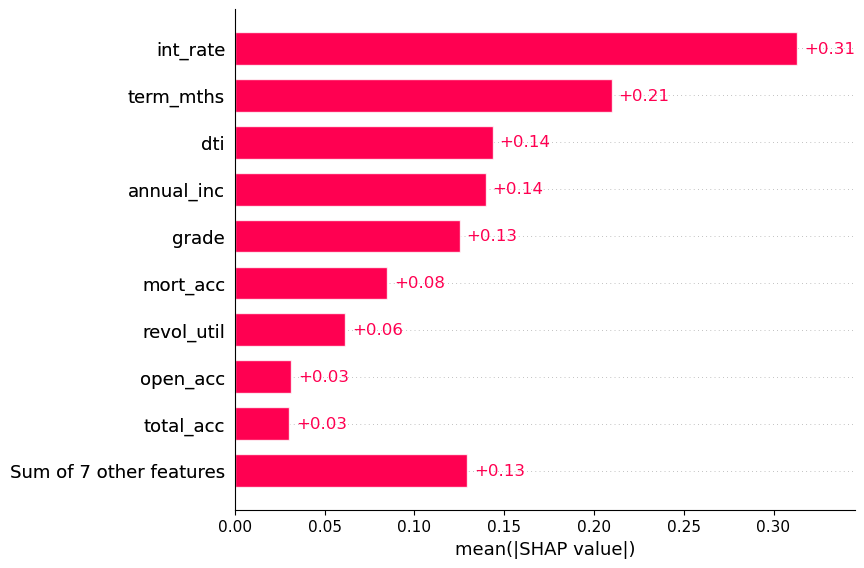

Q5: Top 3 features by SHAP values:
     Feature  Mean_Abs_SHAP
2   int_rate       0.313195
1  term_mths       0.209905
8        dti       0.143638


In [2]:
# Define features and target
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Split the dataset into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Q1: Random Forest Classifier
RF_model = RandomForestClassifier(n_estimators=500, random_state=1, max_features="sqrt", max_depth=34)
RF_model.fit(X_train, y_train)
rf_predictions = RF_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Q1: Random Forest Accuracy:", rf_accuracy)

# Feature Importance for Random Forest
rf_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': RF_model.feature_importances_})
rf_top3_features = rf_importances.sort_values(by='Importance', ascending=False).head(3)
print("Q1: Top 3 features by importance (Random Forest):")
print(rf_top3_features)

# Q2: XGBoost Classifier
XG_model = XGBClassifier(n_estimators=500, random_state=1, learning_rate=0.01, max_depth=4, objective='binary:logistic')
XG_model.fit(X_train, y_train)
xg_predictions = XG_model.predict(X_test)
cm = confusion_matrix(y_test, xg_predictions)

# Confusion Matrix and Metrics
recall_loan_0 = recall_score(y_test, xg_predictions, pos_label=0)
precision_loan_1 = precision_score(y_test, xg_predictions, pos_label=1)
print("Q2: Confusion Matrix:")
print(cm)
print("Q2: Recall for loan_status=0:", recall_loan_0)
print("Q2: Precision for loan_status=1:", precision_loan_1)

# Feature Importance for XGBoost
xg_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': XG_model.feature_importances_})
xg_top3_features = xg_importances.sort_values(by='Importance', ascending=False).head(3)
print("Q2: Top 3 features by importance (XGBoost):")
print(xg_top3_features)

# Q3: Common feature in RF and XGBoost Top 3
common_features = set(rf_top3_features['Feature']).intersection(set(xg_top3_features['Feature']))
print("Q3: Common feature in both models:", common_features)

# Q4: Predict loan_status for two given cases
case_A = pd.DataFrame({
    'loan_amnt': [1000], 'term_mths': [60], 'int_rate': [10], 'installment': [360], 'grade': [1],
    'empl_yrs': [5], 'annual_inc': [10000], 'verification_status': [0], 'dti': [10], 'open_acc': [3],
    'pub_rec': [0], 'revol_bal': [10000], 'revol_util': [50], 'total_acc': [5], 'mort_acc': [1],
    'pub_rec_bankruptcies': [0]
})

case_B = pd.DataFrame({
    'loan_amnt': [1000], 'term_mths': [60], 'int_rate': [8], 'installment': [120], 'grade': [1],
    'empl_yrs': [10], 'annual_inc': [120000], 'verification_status': [1], 'dti': [5], 'open_acc': [1],
    'pub_rec': [0], 'revol_bal': [100000], 'revol_util': [5], 'total_acc': [2], 'mort_acc': [1],
    'pub_rec_bankruptcies': [1]
})

case_A_pred = XG_model.predict(case_A)
case_B_pred = XG_model.predict(case_B)
print(f"Q4: Prediction for Case A: {case_A_pred[0]} (0=No Default, 1=Default)")
print(f"Q4: Prediction for Case B: {case_B_pred[0]} (0=No Default, 1=Default)")

# Q5: SHAP Values Explanation
explainer = shap.Explainer(XG_model, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

# SHAP Top 3 Features
shap_values_df = pd.DataFrame({'Feature': X_train.columns, 'Mean_Abs_SHAP': shap_values.abs.mean(0).values})
shap_top3_features = shap_values_df.sort_values(by='Mean_Abs_SHAP', ascending=False).head(3)
print("Q5: Top 3 features by SHAP values:")
print(shap_top3_features)